# Imports 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# Dataset Paths

In [2]:
# path to the directory with the data
TRAIN_DATA = './stl10_binary/train_X.bin'
TRAIN_LABEL = './stl10_binary/train_y.bin'
TEST_DATA = './stl10_binary/test_X.bin'
TEST_LABEL = './stl10_binary/test_y.bin'
UNLABELED = './stl10_binary/unlabeled_X.bin'

# External and Utility Functions

(1) read_labels and read_all_images function are taken from the STL-10 dataset official page and github link: https://github.com/mttk/STL10/blob/master/stl10_input.py

(2) calculate_mse: Calculates the Mean Squared Error

(3) plot_image: Utility function to plot the image using matplotlib

(4) normalize_dataset: Simply normalize the mean and standard deviation

(5) undo_normalization: Undo the normalization to retrieve the image

In [3]:
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
    
def calculate_mse(reference, result):
    difference = reference - result
    squared = np.square(difference)
    sum_array = np.mean(squared)
    return sum_array

def plot_images(images, title, n_images=9):
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=20)
    side = int(math.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i]
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.show()

def normalize_dataset(dataset):
    mean = []
    std = []
    red = dataset[...,0].reshape((-1,size*size))
    green = dataset[...,1].reshape((-1,size*size))
    blue = dataset[...,2].reshape((-1,size*size))

    red = np.float32(red)
    green = np.float32(green)
    blue = np.float32(blue)

    mean.append(np.mean(red))
    mean.append(np.mean(green))
    mean.append(np.mean(blue))

    red -= mean[0]
    green -= mean[1]
    blue -= mean[2]

    std.append(np.std(red))
    std.append(np.std(green))
    std.append(np.std(blue))

    red /= std[0]
    green /= std[1]
    blue /= std[2]

    print("Red Mean:"+str(np.mean(red))+" Std Dev:"+str(np.std(red)))
    print("Green Mean:"+str(np.mean(green))+" Std Dev:"+str(np.std(green)))
    print("Blue Mean:"+str(np.mean(blue))+" Std Dev:"+str(np.std(blue)))
    
    return red, green, blue, mean, std

def undo_normalization(retrieved_r,retrieved_g,retrieved_b, mean, std):
    retrieved_r *= std[0];
    retrieved_r += mean[0];
    retrieved_g *= std[1];
    retrieved_g += mean[1];
    retrieved_b *= std[2];
    retrieved_b += mean[2];
    return retrieved_r,retrieved_g,retrieved_b

# Dataset Manipulation

Resize the input files to only accept 10,000 images out of 100,000 images. 

Additionally, resize the dimensions of each image by dividing it by two (2). --> (For Faster Processing)

In [4]:
images = read_all_images(UNLABELED)
print('Dataset all images (size): '+str(images.shape))

images_subset = np.copy(images[0:10000])
print('Dataset for project (size) : ' + str(images_subset.shape))

Dataset all images (size): (100000, 96, 96, 3)
Dataset for project (size) : (10000, 96, 96, 3)


In [5]:
resizer = 2
size = math.ceil(96/resizer);
dataset = np.copy(images_subset[:,::resizer,::resizer,:])
print("Resized Images {size}: "+ str(dataset.shape))

Resized Images {size}: (10000, 48, 48, 3)


# PCA Step 1: Normalize the Mean and Std Dev

This step is essentially a subset of how to calculate covariance. Since the general formula for calculating the covariance is only given by $\frac{1}{N}XX^T$. 

This is rather incomplete in computing the covariance matrix as it first needs to be centered, i.e. mean deducted per column, hence this method. The standard deviation normalization per column is for further uniformity but is not done on other sources. 

In [6]:
red, green, blue, mean, std = normalize_dataset(dataset)
r_u, g_u, b_u = mean[0], mean[1], mean[2]
r_std, g_std, b_std = std[0], std[1], std[2]

Red Mean:-4.1975446e-07 Std Dev:0.9999998
Green Mean:-7.64068e-07 Std Dev:1.0000005
Blue Mean:-4.3611527e-07 Std Dev:1.0000008


# PCA Step 2: Covariance Matrix and EigenDecomposition

Since the red, green, and blue matrix are of the size 10000x(2304), we have to transpose it to (2304)x10000 to properly used the formula discussed in the lectures. Hence, $X = A^T. $Upon doing this, we apply the formula $\frac{1}{N}XX^T$ and use eigendecomposition to get the eigenvectors. 

The extra remaining code is for arranging the eigenvector based on its eigenvalues and making the result only real (no imaginary). 

In [7]:
#Set it to the transpose of red, green and blue for the dimensions to be a long slim matrix (columns)
red_T = np.transpose(red)
green_T = np.transpose(green)
blue_T = np.transpose(blue)

cov_red = np.matmul(red_T,red)/(size*size)
cov_green = np.matmul(green_T,green)/(size*size)
cov_blue = np.matmul(blue_T,blue)/(size*size)

e_val_r, e_vec_r = np.linalg.eig(cov_red)
e_val_g, e_vec_g = np.linalg.eig(cov_green)
e_val_b, e_vec_b = np.linalg.eig(cov_blue)

index_r = np.argsort(e_val_r)
index_g = np.argsort(e_val_g)
index_b = np.argsort(e_val_b)

e_vec_r = e_vec_r[:,index_r][:,::-1]
e_vec_g = e_vec_g[:,index_g][:,::-1]
e_vec_b = e_vec_b[:,index_b][:,::-1]

e_vec_r = np.real(e_vec_r)
e_vec_g = np.real(e_vec_g)
e_vec_b = np.real(e_vec_b)

# PCA Step 3: Pseudo Z Code Generation

The Pseudo Z Code generation is given by truncating the eigenvector by the columns and using the following formula: $B_{M}B_{M}^T$. The real Z code would definition would be defined later on in the GMM Part

In [8]:
dimensions = [32, 64, 256, 512, 1028, 2046, 4098]
zcode_r = []
zcode_g = []
zcode_b = []

for i in dimensions:
    e_vec_trunc_r = np.copy(e_vec_r[:,:i])
    e_vec_trunc_g = np.copy(e_vec_g[:,:i])
    e_vec_trunc_b = np.copy(e_vec_b[:,:i])

    zcode_r.append(np.matmul(e_vec_trunc_r,np.transpose(e_vec_trunc_r)))
    zcode_g.append(np.matmul(e_vec_trunc_g,np.transpose(e_vec_trunc_g)))
    zcode_b.append(np.matmul(e_vec_trunc_b,np.transpose(e_vec_trunc_b)))

# PCA Step 4: Retrieve the Original using the Z Code

After getting the $B_{M}B_{M}^T$, we further multiply it by X to the right side like this: $B_{M}B_{M}^TX$. The matrix result 
size would be 2304x10000. We have to further transpose this to have the size of 10000x2304 as is accepted by matplotlib. 

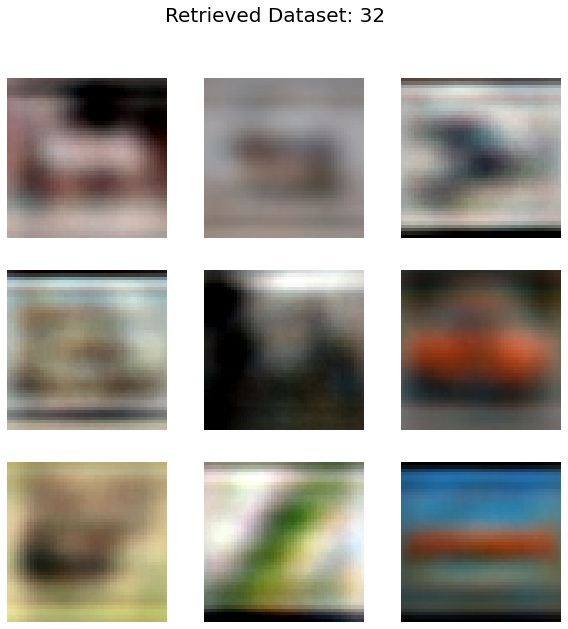

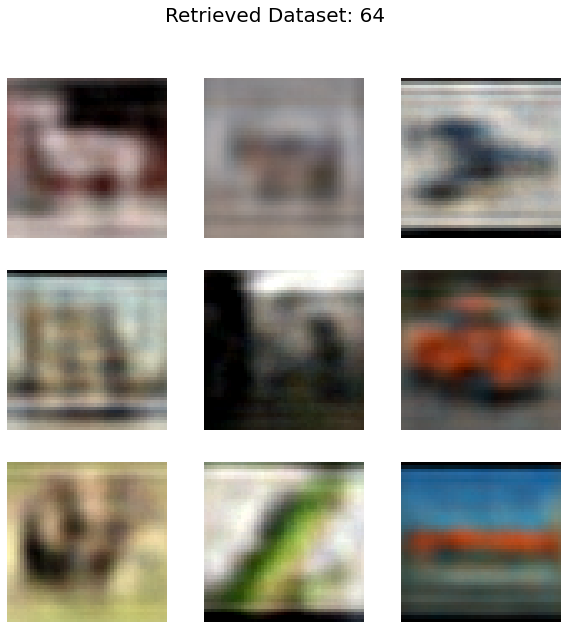

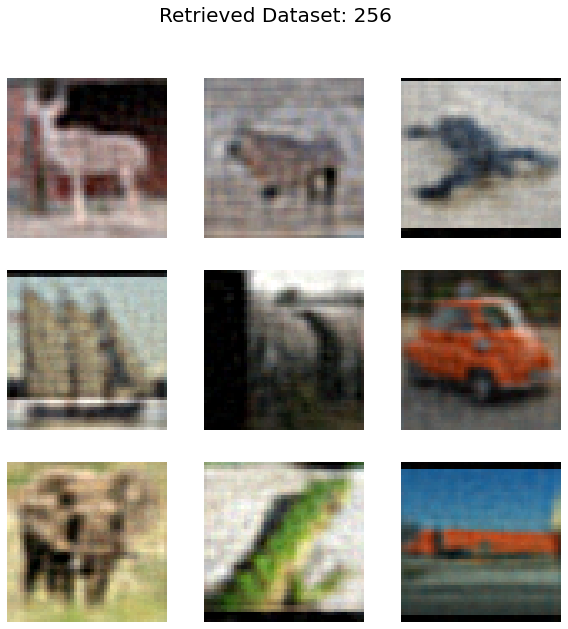

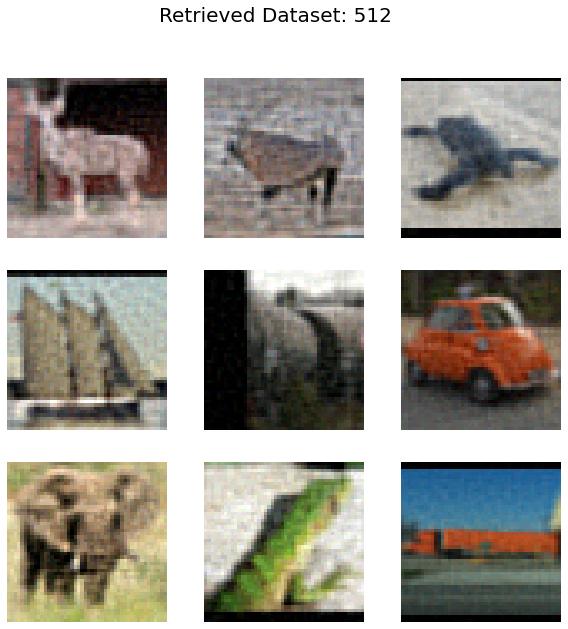

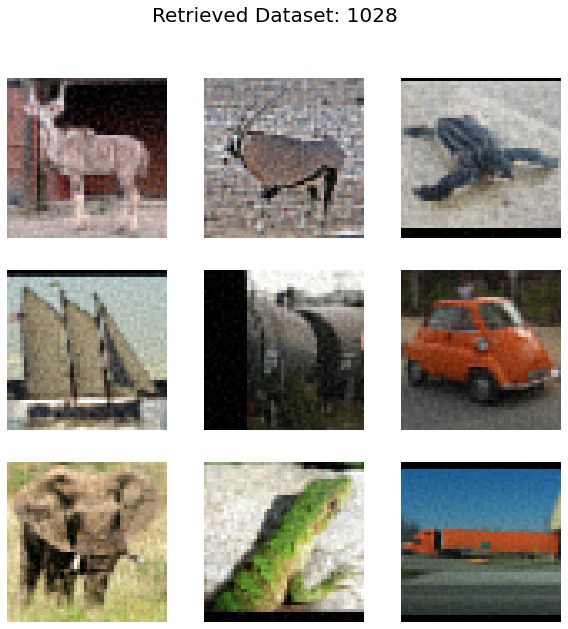

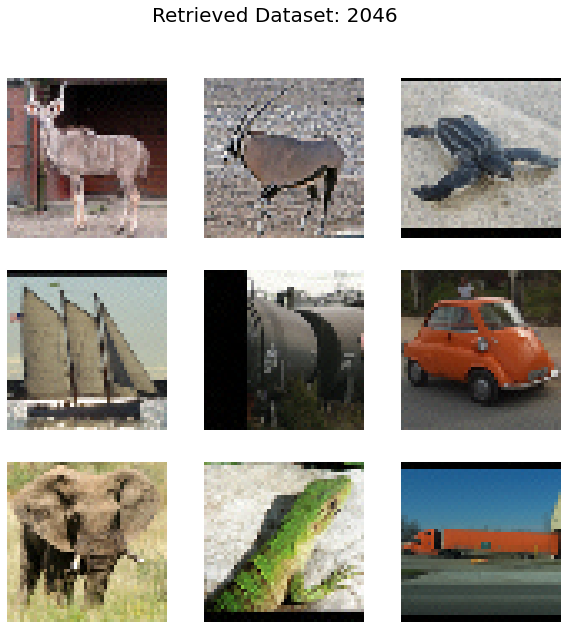

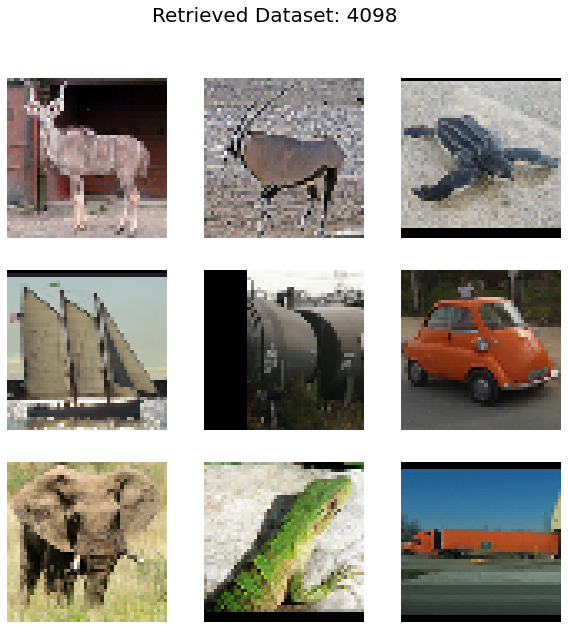

In [9]:
pca_mse_r = []
pca_mse_g = []
pca_mse_b = []

for i in range(len(dimensions)):
    retrieved_r = np.matmul(zcode_r[i],red_T)
    retrieved_g = np.matmul(zcode_g[i],green_T)
    retrieved_b = np.matmul(zcode_b[i],blue_T)

    retrieved_r = np.transpose(retrieved_r)
    retrieved_g = np.transpose(retrieved_g)
    retrieved_b = np.transpose(retrieved_b)
    
    pca_mse_r.append(calculate_mse(retrieved_r,red))
    pca_mse_g.append(calculate_mse(retrieved_g,green))
    pca_mse_b.append(calculate_mse(retrieved_b,blue))

    retrieved_r,retrieved_g,retrieved_b = undo_normalization(retrieved_r,retrieved_g,retrieved_b, mean, std)

    retrieved = np.concatenate((retrieved_r[...,np.newaxis],retrieved_g[...,np.newaxis], retrieved_b[...,np.newaxis]),axis=2)

    retrieved = np.reshape(retrieved,(-1,size,size,3)).astype(np.int32)
    retrieved = np.clip(retrieved,0,255)

    plot_images(retrieved,'Retrieved Dataset: '+str(dimensions[i]))

# Comparing the MSE across all dimensions

Given the result below, the best reconstruction value is at 2046 because the maximum size would be 2304 as expected since if we include more and more dimensions, the reconstruction becomes better and better with the cost of size. 

MSE Value of Dimension 32 is 0.26568177
MSE Value of Dimension 64 is 0.20458658
MSE Value of Dimension 256 is 0.105577625
MSE Value of Dimension 512 is 0.06551074
MSE Value of Dimension 1028 is 0.029230228
MSE Value of Dimension 2046 is 0.0024710165
MSE Value of Dimension 4098 is 9.62907e-14


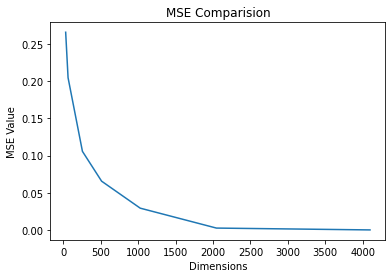

In [10]:
pca_mse = (np.array(pca_mse_r) + np.array(pca_mse_g) + np.array(pca_mse_b))/3

for count, i in enumerate([32, 64, 256, 512, 1028, 2046, 4098]):
    print("MSE Value of Dimension "+str(i)+ " is " +str(pca_mse[count]))

plt.title("MSE Comparision")
plt.xlabel("Dimensions")
plt.ylabel("MSE Value")
plt.plot([32, 64, 256, 512, 1028, 2046, 4098],pca_mse)
plt.show()


# Optional Step: SVD Validation

Instead of doing Step 2, Step 3 and Step 4 of the PCA, we can also do an equivalent method using the SVD (Matrix Decomposition). Considering a matrix A with size m x n, the SVD is defined by the following formula

<h3 align="center"> $ A = U \sum V^T $ </h3> 

Do also note the following: 

<ul>
<li> U is the eigenvectors of $AA^T$ of size mxm (it is also unitary/orthogonal)

<li> $\sum$ is the squareroot of the eigenvalues of both $AA^T$ and $A^TA$ of size mxn (diagonal matrix)

<li> V is the eigenvectors of $A^TA$ of size nxn (it is also unitary/orthogonal)
</ul> 

Also, by using the SVD, we are essentially truncating the columns of the matrix so we must input the matrix A as the size: 10000 x 2304. Given this, V has the size of 2304x2304, which is the same size (and the same eigenvectors) we got from the eigendecomposition. 

The reason behind this is for the PCA, we input the matrix size as: 2304x10000. So $\frac{1}{N} XX^T $ (Step 2 of PCA) is essentially $A^TA$, only being scaled by $1/N$, but the eigenvectors would not changed since by default eigenvectors are normalized. 

Furthermore, the output of the PCA is $B_{M}B_{M}^TX$, which has the corresponding size of 2304x10000 so we have to transpose it, which in equation form would yield the following equation $X^TB_{M}B_{M}^T$. Do note that $X^T$ would be equivalent to our matrix $A$ since we already did the transpose a while ago. Expanding this further would yield the equation: $U \sum V^TB_{M}B_{M}^T$, but $V = B_{M}$, therefore, $U\sum B_{M}^T(B_{M}B_{M}^T) = U \sum B_{M}^T$ [1]. The $ B_{M}^T$ is still truncated similar to PCA and the $U \sum$ matrix should be truncated to match the size of $ B_{M}^T$ as the $U\sum$ matrix(truncated columns) would approximate the matrix $A$ by the Eckard-Young Theorem

[1] An important part of this analysis would depend on knowing that $B_{M}^TB_{M}$ would be equal to the identity matrix (of size: dimensions x dimensions) even when some columns are missing but $B_{M}B_{M}^T$ would NOT be equal to the identity matrix and would instead be of the size 2304x2304. 

Resourced Used: https://www.youtube.com/watch?v=fkf4IBRSeEc&t=704s

In [11]:
def svd_method(color):
    dims = [32, 64, 256, 512, 1028, 2046, 4098]
    mse = []
    all_retrieved = []
    
    a, b, c = np.linalg.svd(color)
    b_changed = np.concatenate((np.diag(b),np.zeros((10000 - int(size*size),int(size*size)))),axis=0)
    principal_components = np.matmul(a,b_changed)         #SVD Property
    retrieved = np.matmul(principal_components,c)         #Reference
    for i in dims:
        retrieved_low = np.matmul(principal_components[:,0:i], c[0:i,:])  #Eckard-Young Theorem
        all_retrieved.append(retrieved_low)
        mse.append(calculate_mse(retrieved,retrieved_low))
    
    return all_retrieved, mse

In [12]:
red_low, red_mse = svd_method(red)
green_low, green_mse = svd_method(green)
blue_low, blue_mse = svd_method(blue)

# Show Sample Of Reconstruction

(10000, 2304, 3)
(10000, 48, 48, 3)


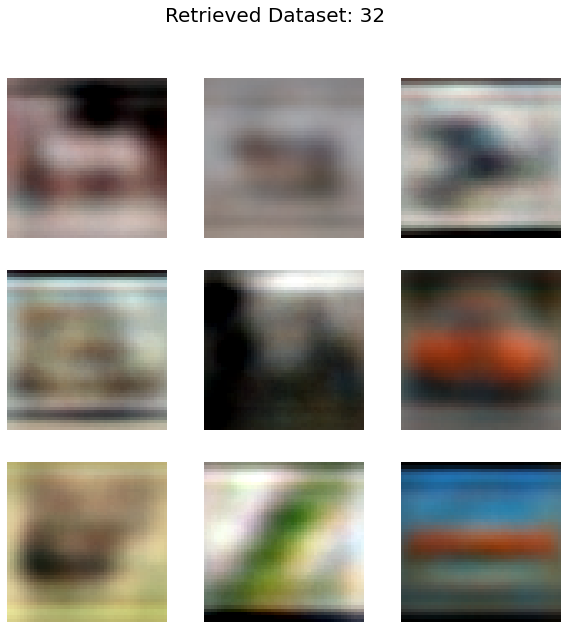

(10000, 2304, 3)
(10000, 48, 48, 3)


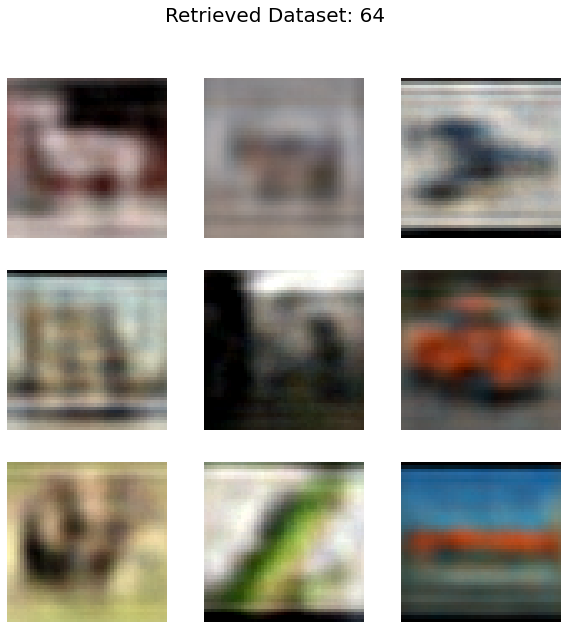

(10000, 2304, 3)
(10000, 48, 48, 3)


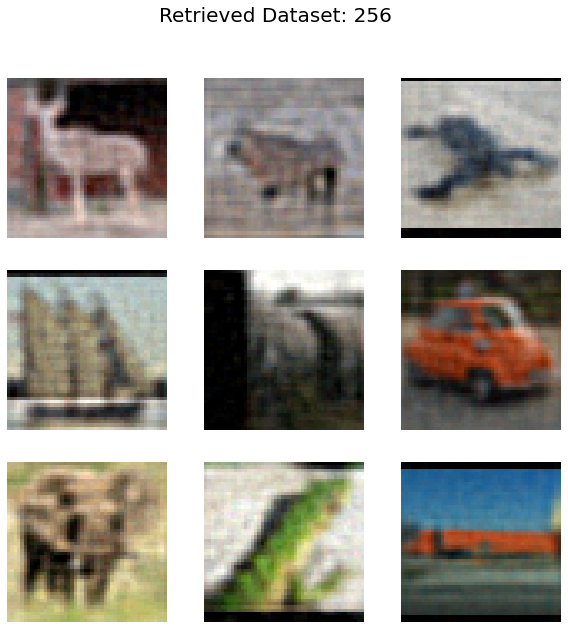

(10000, 2304, 3)
(10000, 48, 48, 3)


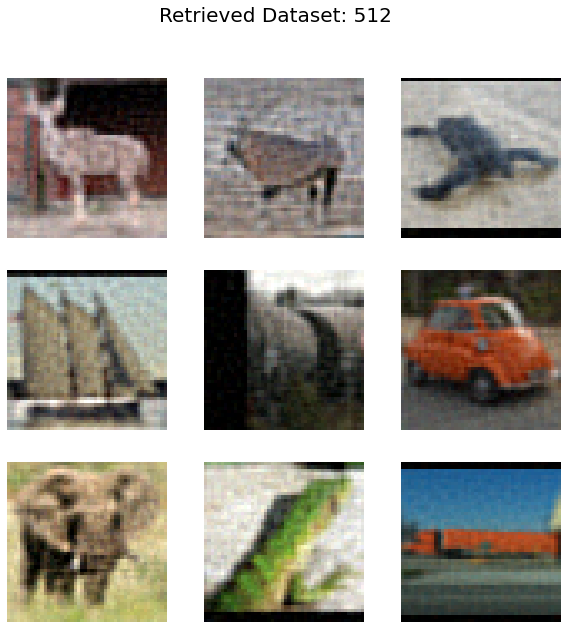

(10000, 2304, 3)
(10000, 48, 48, 3)


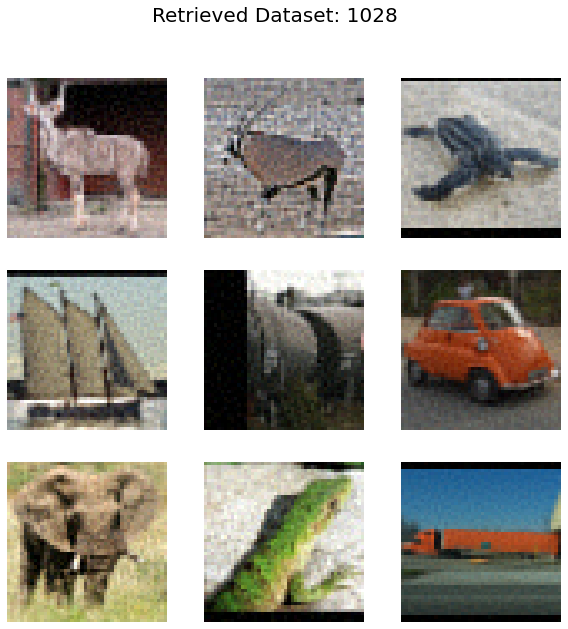

(10000, 2304, 3)
(10000, 48, 48, 3)


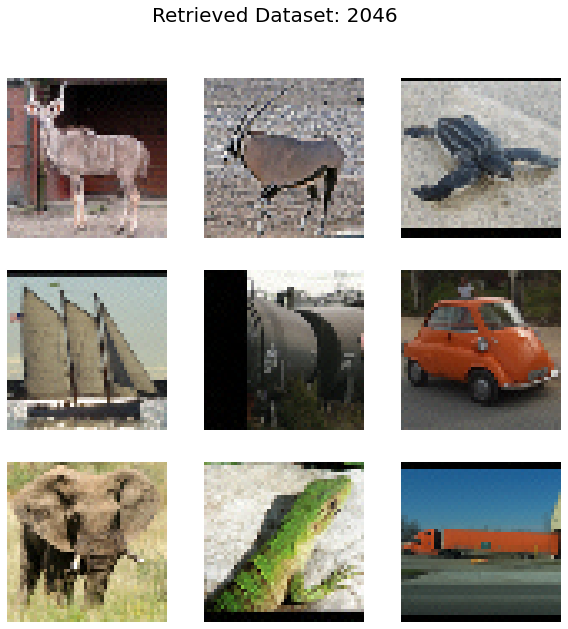

(10000, 2304, 3)
(10000, 48, 48, 3)


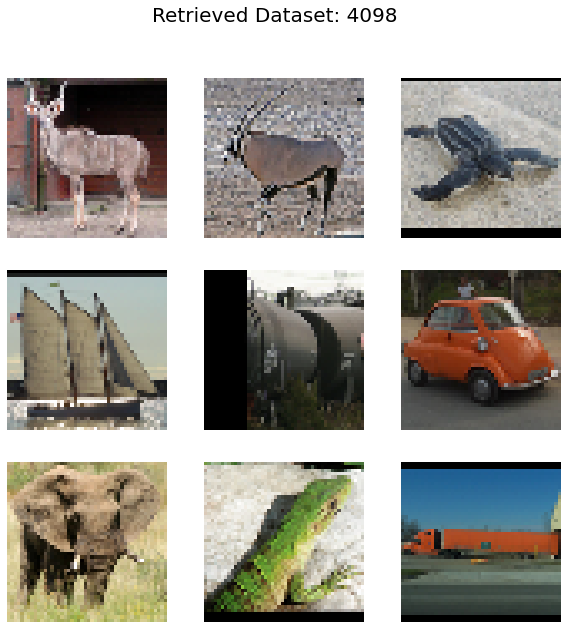

In [13]:
for i in range(len(red_low)):
    red_low[i] *= r_std;
    red_low[i] += r_u;
    green_low[i] *= g_std;
    green_low[i] += g_u;
    blue_low[i] *= b_std;
    blue_low[i] += b_u;

    final_low = np.concatenate((red_low[i][...,np.newaxis],green_low[i][...,np.newaxis], blue_low[i][...,np.newaxis]),axis=2)
    print(final_low.shape)
    final_low = (final_low).reshape(10000,size,size,3).astype(np.int32)
    print(final_low.shape)
    final_low = np.clip(final_low, 0, 255)
    plot_images(final_low,'Retrieved Dataset: '+str(dimensions[i]))





# Comparing the MSE across all dimensions

Given the result below, the best reconstruction value is at 2046 because the maximum size would be 2304 as expected since if we include more and more dimensions, the reconstruction becomes better and better with the cost of size. 

### Note that the values of the MSE are truly the same with the MSE value computed using the PCA method

MSE Value of Dimension 32 is 0.2656817522227549
MSE Value of Dimension 64 is 0.204586483703696
MSE Value of Dimension 256 is 0.1055775191161749
MSE Value of Dimension 512 is 0.06551075096600019
MSE Value of Dimension 1028 is 0.029230233715991205
MSE Value of Dimension 2046 is 0.0024710149668665444
MSE Value of Dimension 4098 is 0.0


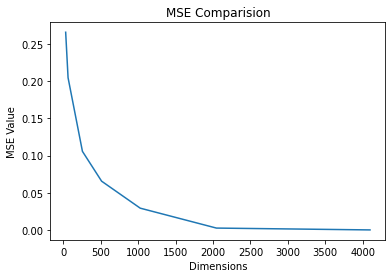

In [14]:
final_mse = (np.array(red_mse) + np.array(green_mse) + np.array(blue_mse))/3

for count, i in enumerate([32, 64, 256, 512, 1028, 2046, 4098]):
    print("MSE Value of Dimension "+str(i)+ " is " +str(final_mse[count]))

plt.title("MSE Comparision")
plt.xlabel("Dimensions")
plt.ylabel("MSE Value")
plt.plot([32, 64, 256, 512, 1028, 2046, 4098],final_mse)
plt.show()


# GMM Step 0: Definition of Z Code and Z Dimension Used

In order to retrieved the results from PCA, we used the following formula: $B_{M}B_{M}^TX$. We have to first to the transpose since our X has the size of 10000 x 2304. We get: $X^TB_{M}B_{M}^T$. Do note that this is composed of three matrices. We can label $B_{M}$ as sort of an "encoder" while $B_{M}^T$ as the decoder. Hence, the Z code (from here on) can be defined as $Z = X^TB_{M}$. Again, do note that $X^T = A$.

Also, for the Z-Dimensions, 256 seems to be the logical choice out of all the Z Dimensions. This is due to 2046 being too closed to 2304 hence rendering the PCA compression quite useless. 1028 and 512 seems to have capped already since the difference on the MSE is only 0.04 while the difference of 256 and 512 is 0.1. Although what I eventually settle with would be the 128 dimension since as the dimension decrease, the Negative log likelihood would also decrease since GMM would need to less dimensions to model, the cons would be a less clear output/reproduction.

In [15]:
def get_z_codes(z_dim,red,green,blue):
    eigen_trunc_r = np.copy(e_vec_r[:,:z_dim])
    eigen_trunc_g = np.copy(e_vec_g[:,:z_dim])
    eigen_trunc_b = np.copy(e_vec_b[:,:z_dim])
    z_dim *= 3

    z_code_r = np.matmul(red,eigen_trunc_r)
    z_code_g = np.matmul(green,eigen_trunc_g)
    z_code_b = np.matmul(blue,eigen_trunc_b)

    z_code = np.hstack([z_code_r,z_code_g,z_code_b])
    
    return z_code, z_dim

z_code, z_dim = get_z_codes(128,red,green,blue)

# GMM Step 1: Initialize Mean, Covariance Matrix, and Weights

Resource Used: https://github.com/roatienza/ml/blob/master/gmm/notebook/gmm.ipynb

In [16]:
from scipy.stats import multivariate_normal
n_components = 10

mu_shape = (n_components,z_dim)
mu = np.random.normal(size=mu_shape)
sigma = [np.identity(z_dim) for _ in range(n_components)]
sigma_shape = np.array(sigma).shape
pi = np.random.randint(1,100,size=(n_components,1))
pi = pi/pi.sum()
pi_shape = pi.shape

print("Mean Shape: ",mu_shape)
print("Covariance Shape: ",sigma_shape)
print("Weights Shape: ",pi_shape)

Mean Shape:  (10, 384)
Covariance Shape:  (10, 384, 384)
Weights Shape:  (10, 1)


# GMM Step 2 and 3: Expectation Maximiation (EM) Algorithm

### Step 2: Expectation
![responsibility](respon.png)
### Step 3: Maximization 
![mean](mean.png)

Image Taken from: Resource Used: https://github.com/roatienza/ml/blob/master/gmm/notebook

In [17]:
n_loop = 20
nll = []          #Negative Log Likelihood

for loop in range(n_loop):
    #Compute Gaussian
    rv = [multivariate_normal(mu[i], sigma[i], allow_singular = True) for i in range(n_components)]
    g_val = np.array([rv[i].pdf(z_code) for i in range(n_components)])
    g_val += 1e-300   #Minimum value is -323 but for some margin -300 to not be NaN, to avoid logarithmic underflow
    #g_val's Shape: 10x10000
    
    #Negative Log Likelihood
    weighted_g_val = np.array([pi[i]*g_val[i] for i in range(n_components)])
    weighted_g_val = weighted_g_val.sum(axis=0)
    weighted_g_val = np.log(weighted_g_val).sum()
    nll.append(-weighted_g_val)

    #Compute Responsibilities
    p = np.repeat(pi, z_code.shape[0], axis=1)  #Do in order ot have same size with g_val (10x10000)
    r = np.multiply(p, g_val)
    r = np.divide(r, np.sum(r, axis = 0)) #Main Formula, Divide each k by the sum
    
    #Compute Nk
    Nk = r.sum(axis=1)   #Size is 10 since the N=10,000 is already summed
    Nk = np.repeat(Nk, z_dim, axis=0)   #Size is 10*z_dim to accomodate all dimensions
    
    # Update Means
    r = np.repeat(r, z_dim, axis=0)  #Size is 10*z_dimx10000 to accomodate all dimensions
    x_t = [z_code.transpose() for _ in range(n_components)]
    x_t = np.concatenate(x_t, axis=0) #Size is 10*z_dimx10000
    # responsibilities x data
    mu = np.multiply(r, x_t).sum(axis=1)
    # divide by Nk for all k
    mu = np.divide(mu, Nk)   #Size is 3840
    # reshape for sigma computation
    mu = np.reshape(mu, [-1, 1])   #Size is 3840x1
    
    # Update Covariance Matrices
    x_t = x_t - mu
    x_tt = np.copy(x_t)
    x_t = np.multiply(x_t, r)
    x_t = np.reshape(x_t, (n_components, z_dim, -1))
    x_tt = np.reshape(x_tt, (n_components, z_dim, -1))
    sigma = [np.matmul(x_t[i], x_tt[i].transpose()) for i in range(x_t.shape[0])]
    
    #Outer Product
    N = np.reshape(Nk, (-1,1))
    N = np.repeat(N, z_dim, axis=1)
    N = np.reshape(N, (n_components, z_dim, z_dim))
    sigma = [np.divide(sigma[i], N[i,...]) for i in range(n_components)]
    
    #Updating Weights
    for i in range(n_components):
        pi[i] = Nk[i]/z_code.shape[0]
        
    #Restore Means and Covariance shapes
    mu = mu.reshape(mu_shape)
    sigma - np.reshape(np.array(sigma),sigma_shape)

# Graph the Negative Log Likelihood (NLL) over 20 iterations

20 iteration has been chosen since it clearly shows that it converge around 12 iteration and the extra iteration are only there to show the saturation


NLL: [6907728.529979214, 5307467.261596933, 5288802.524110343, 4965986.986642635, 4881697.012183383, 4796172.804245526, 4721354.186486919, 4627241.222069029, 4569816.523609471, 4547322.364117509, 4543146.515394922, 4540641.133256787, 4539066.931679096, 4537695.974712201, 4536657.946832253, 4536239.8126944415, 4535726.993082981, 4535302.461597384, 4535050.907737171, 4534921.607757996]


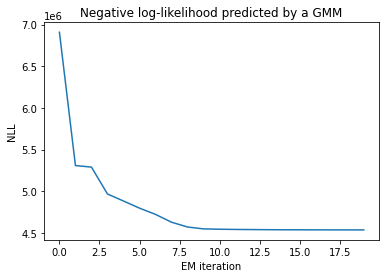

In [18]:
print("NLL:",nll)
x = [loop for loop in range(n_loop)]
plt.plot(x,nll)
plt.title('Negative log-likelihood predicted by a GMM')
plt.xlabel('EM iteration')
plt.ylabel('NLL')
plt.show() 

# Label Train and Test Data Set Setup

Load the Label Train and Test Dataset and resize it by the same factor as the unlabel dataset

In [19]:
train_images = read_all_images(TRAIN_DATA)
train_labels = read_labels(TRAIN_LABEL)
test_images = read_all_images(TEST_DATA)
test_labels = read_labels(TEST_LABEL)
print('Dataset train images (size): '+str(train_images.shape))
print('Dataset train labels (size): '+str(train_labels.shape))
print('Dataset test images (size): '+str(test_images.shape))
print('Dataset test labels (size): '+str(test_labels.shape))

#Trim by a factor of 10 to be uniform with unlabel dataset
train_images_subset = np.copy(train_images[0:5000])
train_labels_subset = np.copy(train_labels[0:5000])
test_images_subset = np.copy(test_images[0:8000])
test_labels_subset = np.copy(test_labels[0:8000])
print('Train Dataset for project (size) : ' + str(train_images_subset.shape))
print('Train Labels for project (size) : ' + str(train_labels_subset.shape))
print('Test Dataset for project (size) : ' + str(test_images_subset.shape))
print('Test Labels for project (size) : ' + str(test_labels_subset.shape))

train_dataset = np.copy(train_images_subset[:,::resizer,::resizer,:])
test_dataset = np.copy(test_images_subset[:,::resizer,::resizer,:])
print("Train Resized Images {size}: "+ str(train_dataset.shape))
print("Test Resized Images {size}: "+ str(test_dataset.shape))

class_names = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']

Dataset train images (size): (5000, 96, 96, 3)
Dataset train labels (size): (5000,)
Dataset test images (size): (8000, 96, 96, 3)
Dataset test labels (size): (8000,)
Train Dataset for project (size) : (5000, 96, 96, 3)
Train Labels for project (size) : (5000,)
Test Dataset for project (size) : (8000, 96, 96, 3)
Test Labels for project (size) : (8000,)
Train Resized Images {size}: (5000, 48, 48, 3)
Test Resized Images {size}: (8000, 48, 48, 3)


# Function to get the maximum cluster belonging to that image 
There would be 5000 images for the Train Dataset and 8000 images for the test dataset. 



In [20]:
def get_max_cluster(z_dim,red,green,blue):
    gmm_z_code, gmm_z_dim = get_z_codes(z_dim,red,green,blue)

    rv = [multivariate_normal(mu[i], sigma[i], allow_singular = True) for i in range(n_components)]
    gmm_g_val = np.array([pi[i]*rv[i].pdf(gmm_z_code) for i in range(n_components)])
    max_indices = np.argmax(gmm_g_val,axis=0)
    return max_indices

# Cluster-Labeling

Do note that some cluster will repeat its name since the algorithm used here only takes the most frequent cluster label according to the train labels. Based from the clustering labeling, there is only two, three, (rarely) four dominant clusters. These results are not good based on the get-go, we can expect the accuracy to be really low on the test dataset. 

In [24]:
num_samples = 100
z_dim =128
final_samples = 0

red, green, blue, mean, std = normalize_dataset(train_dataset)
r_u, g_u, b_u = mean[0], mean[1], mean[2]
r_std, g_std, b_std = std[0], std[1], std[2]

max_indices = get_max_cluster(z_dim,red,green,blue)
for i in range(1,n_components+1):
    label_indices = np.where(train_labels_subset == i)
    cluster_count = np.bincount(max_indices[label_indices])
    print("Cluster "+str(i)+" : "+class_names[np.argmax(cluster_count)])


Red Mean:7.798937e-09 Std Dev:1.0000004
Green Mean:-5.1237214e-07 Std Dev:0.9999992
Blue Mean:-5.3416886e-07 Std Dev:1.0
Cluster 1 : airplane
Cluster 2 : cat
Cluster 3 : airplane
Cluster 4 : airplane
Cluster 5 : cat
Cluster 6 : cat
Cluster 7 : cat
Cluster 8 : cat
Cluster 9 : airplane
Cluster 10 : airplane


# Test Data

Simply get the maximum cluster but do not label it, rather test its accuracy later

In [25]:
red, green, blue, mean, std = normalize_dataset(test_dataset)
r_u, g_u, b_u = mean[0], mean[1], mean[2]
r_std, g_std, b_std = std[0], std[1], std[2]

max_indices = get_max_cluster(z_dim,red,green,blue)

Red Mean:1.2118286e-07 Std Dev:1.0000001
Green Mean:6.352928e-07 Std Dev:1.0
Blue Mean:9.221501e-07 Std Dev:1.0000001


# Report The Percentage of Correct

The results seems to be at best at 15%. This level of accuracy is not an accurate enough to act as a classifier. This is further hinted by the assigning the clusters using the training dataset. There are simply too much repetition in the clusters name hence rendering the classfier to fail from the get-go.

In [26]:
correct = 0
for i in range(max_indices.shape[0]):
    if(max_indices[i] == test_labels[i]-1):
        correct += 1
    else:
        correct += 0

result = correct/max_indices.shape[0]
print(str(result*100)+" percent")

11.2125 percent


# GMM Reproduction using PCA Decoder

As seen from the results, it would not be wise to use the GMM as an STL generative model. This might be attributed to to little components as seen from the accuracy results above. It needs to have further components to be a generative model. 


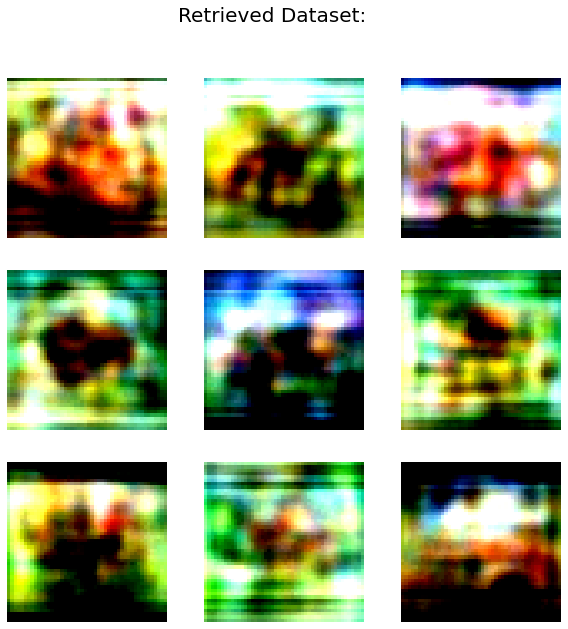

In [27]:
rv = [multivariate_normal(mu[i], sigma[i], allow_singular = True) for i in range(n_components)]

for i in range(n_components):
    final_samples += pi[i]*rv[i].rvs(num_samples)
    
gmm_red = np.matmul(final_samples[:,0:z_dim],e_vec_r[:,:z_dim].transpose())
gmm_green = np.matmul(final_samples[:,z_dim:2*z_dim],e_vec_g[:,:z_dim].transpose())
gmm_blue = np.matmul(final_samples[:,2*z_dim:3*z_dim],e_vec_b[:,:z_dim].transpose())

gmm_red *= r_std;
gmm_red += r_u;
gmm_green *= g_std;
gmm_green += g_u;
gmm_blue *= b_std;
gmm_blue += b_u;

gmm = np.concatenate((gmm_red[...,np.newaxis],gmm_green[...,np.newaxis], gmm_blue[...,np.newaxis]),axis=2)

gmm = np.reshape(gmm,(-1,size,size,3)).astype(np.int32)
gmm = np.clip(gmm,0,255)

plot_images(gmm,'Retrieved Dataset: ')